In [1]:
#Import and Install Dependencies
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

In [2]:
pwd

'C:\\Users\\Soldo\\Desktop\\BirdNet'

In [5]:
BLRA_FILE = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_BLRA_Calls\\BR_Call_1.wav'

In [23]:
NOT_BLRA_FILE = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_Not_BLRA_Clips\\afternoon-birds-song-in-forest-0.wav'

In [20]:
#Build Data Loading Function
def load_wav_16k_mono(file_name):
    #Load encoded wav file
    file_contents = tf.io.read_file(file_name)
    # Decode wav (tensor by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hx - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [21]:
# Plot Wave
wave = load_wav_16k_mono(BLRA_FILE)

In [24]:
nwave = load_wav_16k_mono(NOT_BLRA_FILE)

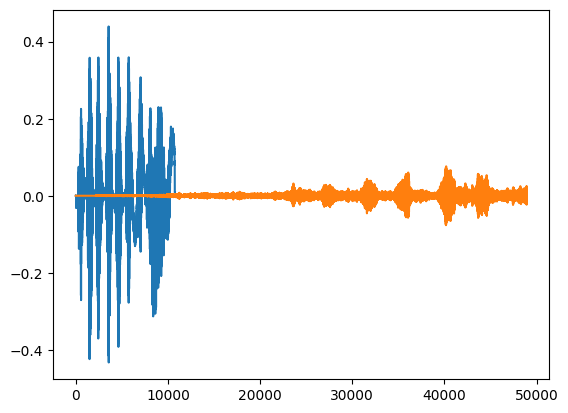

In [25]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [40]:
pwd

'C:\\Users\\Soldo\\Desktop\\BirdNet'

In [47]:
POS = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_BLRA_Calls'
NEG = 'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_Not_BLRA_Clips'

In [48]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

In [49]:
pos.as_numpy_iterator().next()

b'C:\\Users\\Soldo\\Desktop\\BirdNet\\Parsed_BLRA_Calls\\BR_Call_5.wav'

In [50]:
len(pos)

6

In [51]:
len(neg)

593

In [52]:
# Add labels and combine positive and negative samples
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [55]:
# Determine the average length of a black rail call
# Calculate wave cycle length
lengths=[]
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
    lengths.append(len(tensor_wave))

In [56]:
lengths

[10753, 10236, 10017, 10114, 7342, 12631]

In [57]:
# Calculate Mean, Min, and Max
mean = tf.math.reduce_mean(lengths)
min = tf.math.reduce_min(lengths)
max = tf.math.reduce_max(lengths)

print(mean, min, max)

tf.Tensor(10182, shape=(), dtype=int32) tf.Tensor(7342, shape=(), dtype=int32) tf.Tensor(12631, shape=(), dtype=int32)


In [58]:
# Build preprocessing function to convert to spectrogram
# Build preprocessing function

def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:12000]
    zero_padding = tf.zeros([12000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [75]:
# Test out the function and viz of the spectrogram
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [76]:
spectrogram, label = preprocess(filepath, label)

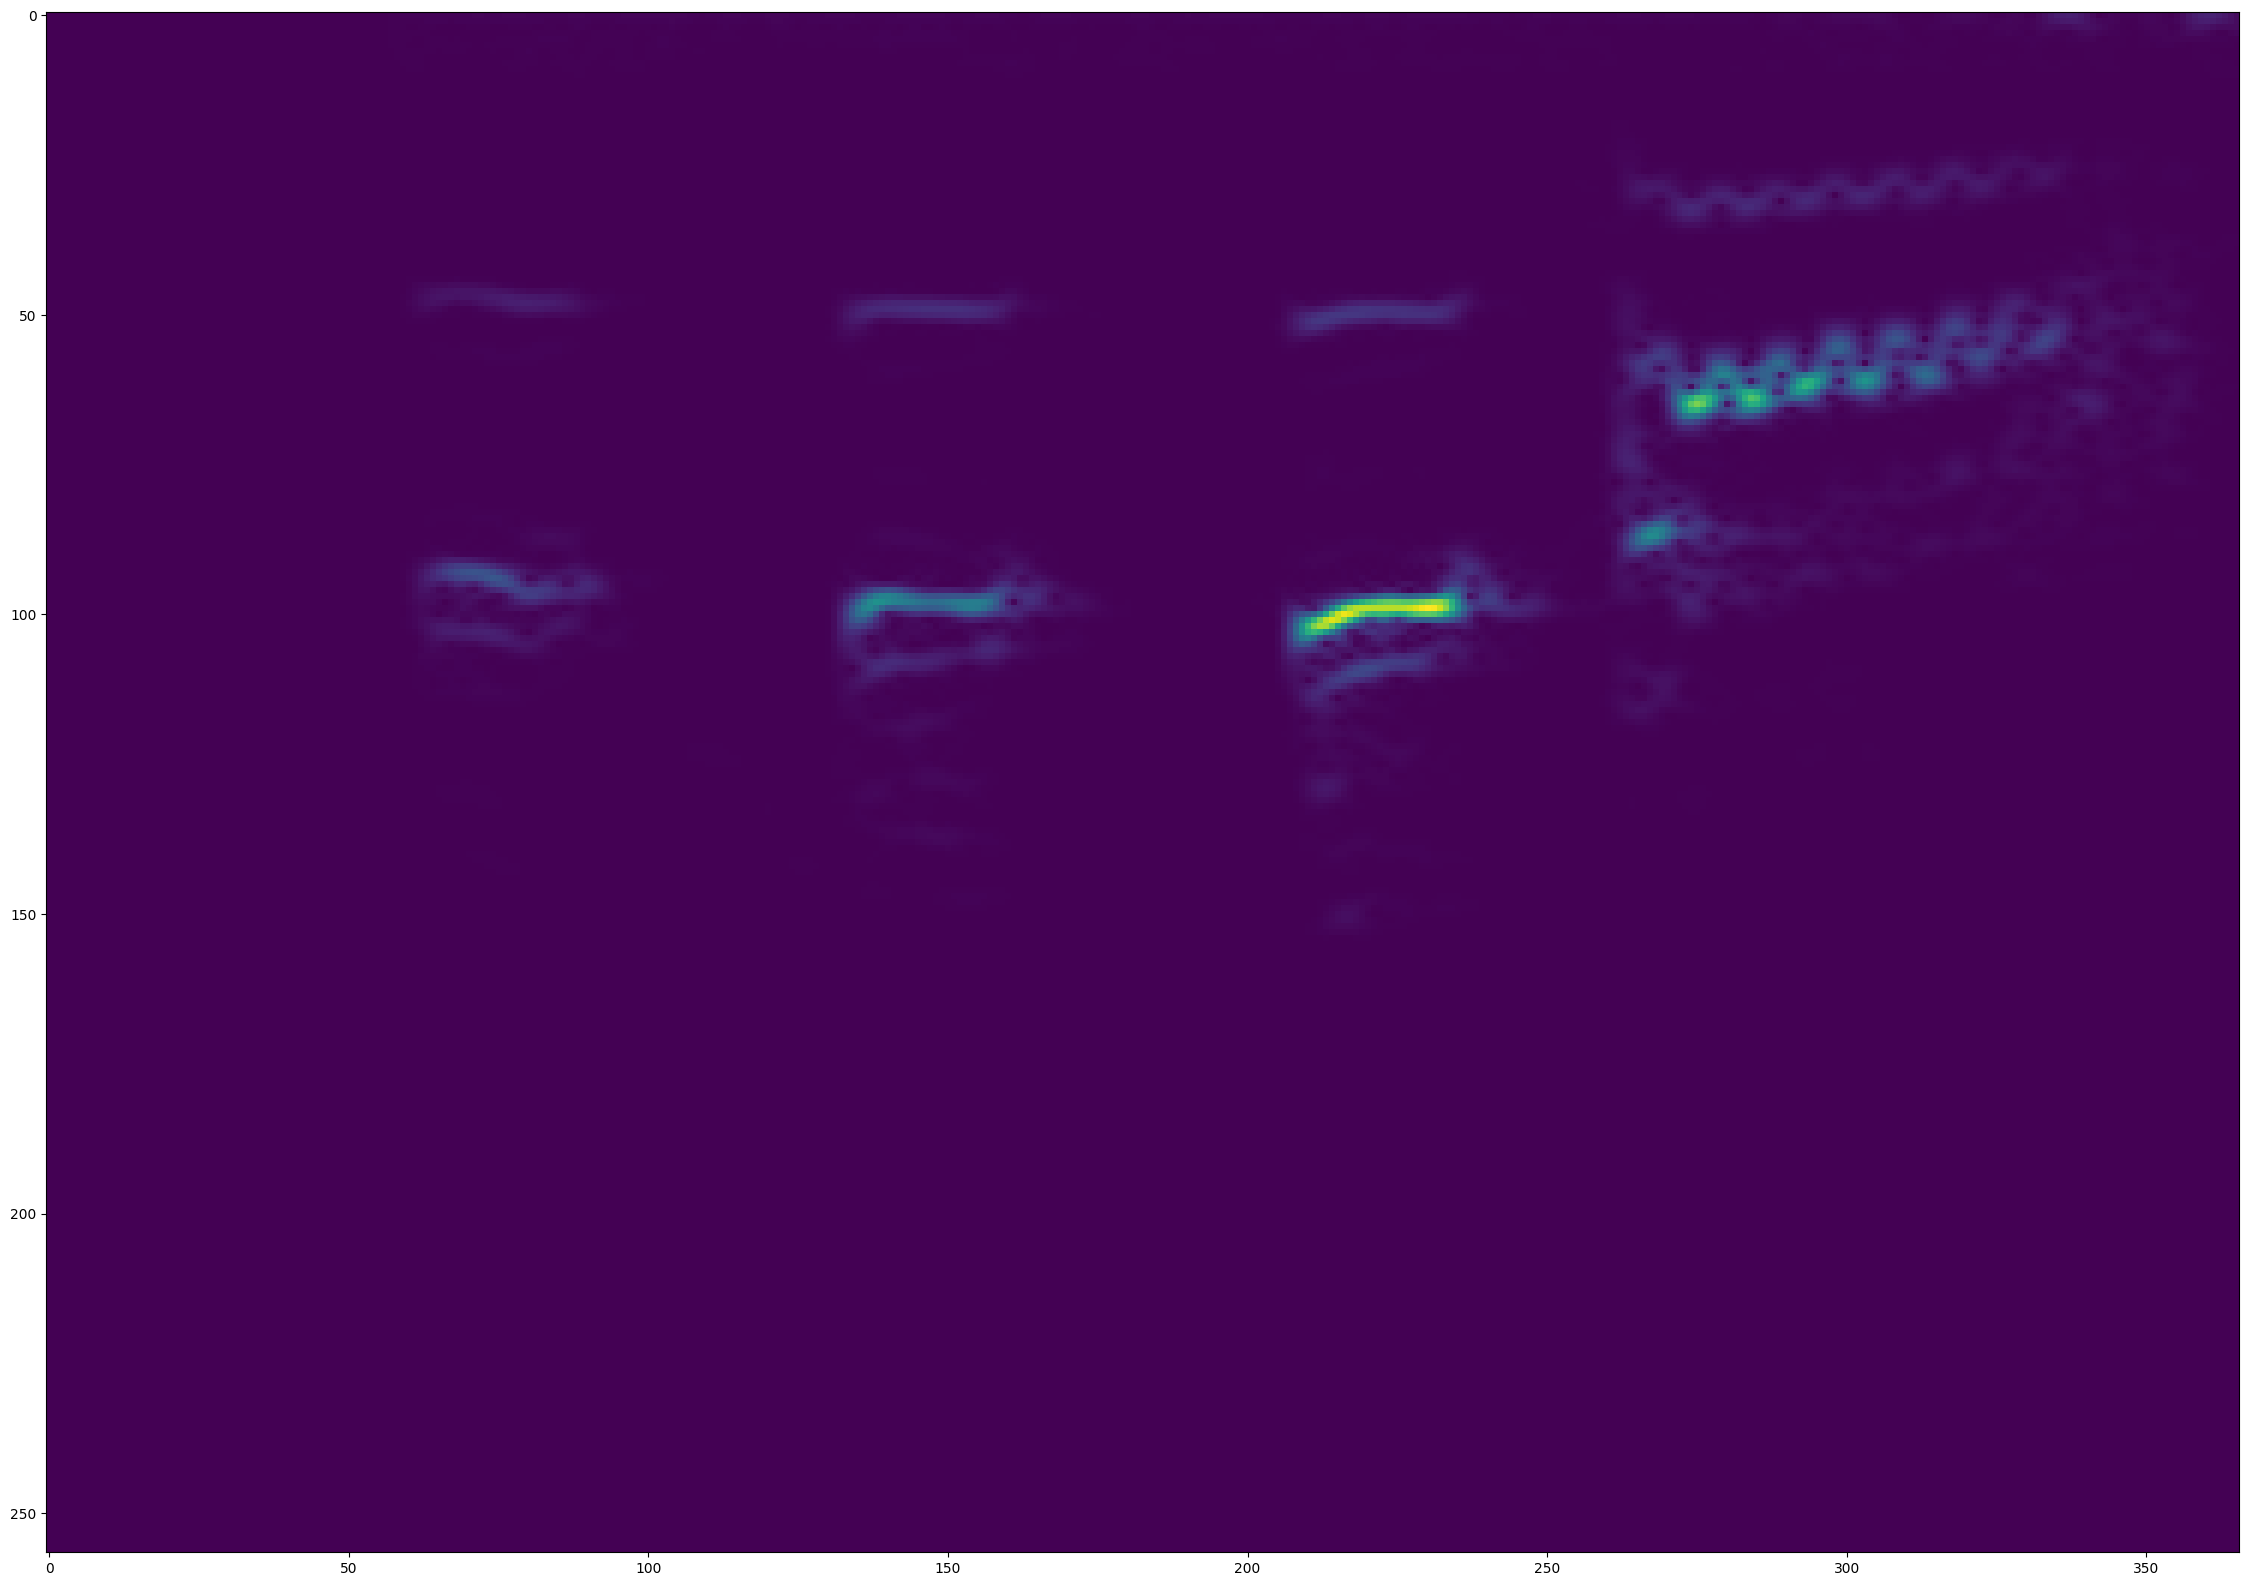

In [77]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [78]:
# Create training and testing partitions
# Create a tensorflow data pipeline

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [79]:
# Split into training and testing partitions
len(data)

38

In [80]:
train = data.take(20)
test = data.skip(20).take(18)

In [81]:
# Test One Batch
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 366, 257, 1)